# 1. 2D Patch Extraction from 3D Volume

In [5]:
# Turn off warnings
import warnings

warnings.filterwarnings('ignore')

In [24]:
import numpy as np
import matplotlib.pyplot as plt
import segyio
import os
import pandas as pd

In [7]:
filePath_noisy = '/home/roderickperez/DS_projects/autoencoders/data/InforPetrol/seismicOriginal/InfoP_noisy.segy'
filePath_noiseless = '/home/roderickperez/DS_projects/autoencoders/data/InforPetrol/seismicOriginal/InfoP_noiseless.segy'

### Load Noisy Dataset

In [8]:
with segyio.open(filePath_noisy, mode = "r", iline = 189, xline = 193) as s:
    cubeNoisy = segyio.cube(s)

In [9]:
cubeNoisy.shape

(351, 4097, 1751)

### Load Noiseless Dataset

In [10]:
with segyio.open(filePath_noiseless, mode = "r", iline = 189, xline = 193) as s:
    cubeNoiseless = segyio.cube(s)

In [11]:
cubeNoiseless.shape

(351, 4097, 1751)

---

In [12]:
# Select a random value for the inline, crossline, time slice
iline = np.random.randint(0, cubeNoisy.shape[0])
xline = np.random.randint(0, cubeNoisy.shape[1])
time = np.random.randint(0, cubeNoisy.shape[2])

---

In [13]:
amplitude_max = np.percentile(cubeNoisy, 98)
amplitude_max

7.233442306518555

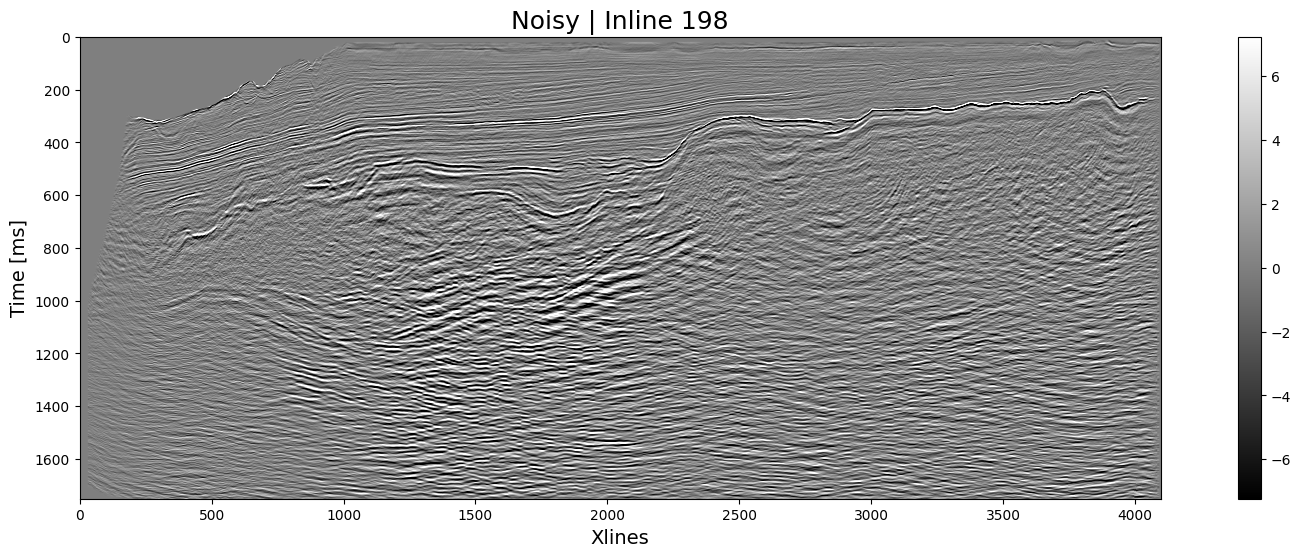

In [15]:
# Visualize the inline
plt.figure(figsize=(20, 6))
plt.imshow(cubeNoisy[iline, :, :].T, cmap = 'gray', aspect='equal', vmin = -amplitude_max, vmax = amplitude_max)
plt.colorbar()
plt.xlabel('Xlines', fontsize = 14)
plt.ylabel('Time [ms]', fontsize = 14)
plt.title('Noisy | Inline %d' %iline, fontsize = 18)
plt.savefig('/home/roderickperez/DS_projects/autoencoders/images/Seismic/InforP/Noisy_Inline_%d.png' %iline)
plt.show()

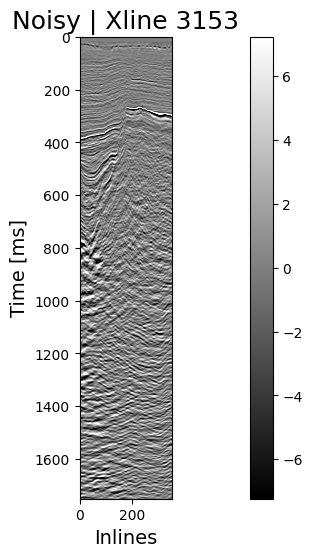

In [17]:
# Visualize the crossline
plt.figure(figsize=(20, 6))
plt.imshow(cubeNoisy[:, xline, :].T, cmap = 'gray', aspect='equal', vmin = -amplitude_max, vmax = amplitude_max)
plt.colorbar()
plt.xlabel('Inlines', fontsize = 14)
plt.ylabel('Time [ms]', fontsize = 14)
plt.title('Noisy | Xline %d' %xline, fontsize = 18)
plt.savefig('/home/roderickperez/DS_projects/autoencoders/images/Seismic/InforP/Noisy_Xline_%d.png' %xline)
plt.show()

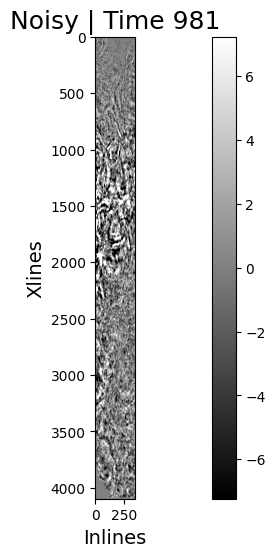

In [16]:
# Visualize the time slice
plt.figure(figsize=(20, 6))
plt.imshow(cubeNoisy[:, :, time].T, cmap = 'gray', aspect='equal', vmin = -amplitude_max, vmax = amplitude_max)
plt.colorbar()
plt.xlabel('Inlines', fontsize = 14)
plt.ylabel('Xlines', fontsize = 14)
plt.title('Noisy | Time %d' %time, fontsize = 18)
plt.savefig('/home/roderickperez/DS_projects/autoencoders/images/Seismic/InforP/Noisy_Xline_%d.png' %time)
plt.show()

---

Compose image

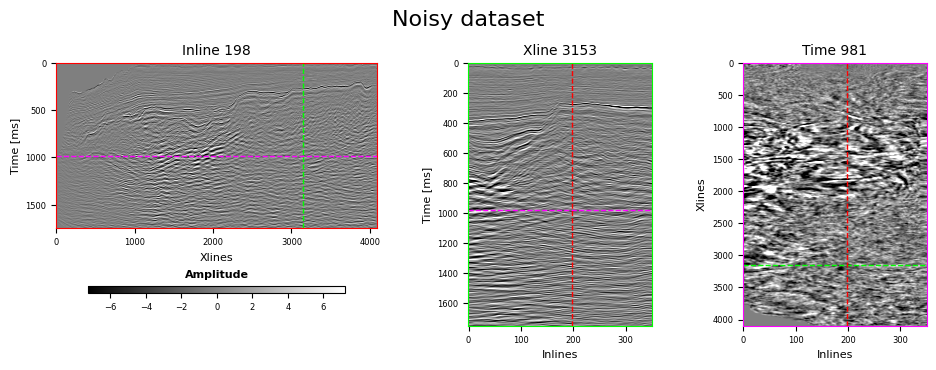

In [151]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10,4))

plt.subplot(3,7,(1, 17))
# Change the frame color to red
ax = plt.gca()
ax.spines['bottom'].set_color('red')
ax.spines['top'].set_color('red')
ax.spines['right'].set_color('red')
ax.spines['left'].set_color('red')

plt.imshow(cubeNoisy[iline, :, :].T, aspect = 'auto', cmap = 'gray', vmin = -amplitude_max, vmax = amplitude_max)
plt.xlabel('Xlines', fontsize = 8)
plt.ylabel('Time [ms]', fontsize = 8)
plt.title('Inline %d' %iline, fontsize = 10)
plt.xticks(fontsize = 6)
plt.yticks(fontsize = 6)

plt.axhline(y = time, color = 'magenta', linestyle = '--', linewidth = 1)
plt.axvline(x = xline, color = 'lime', linestyle = '--', linewidth = 1)

cb = plt.colorbar(orientation='horizontal', pad = 0.22, shrink = 0.8, aspect = 40)

cb.ax.set_title('Amplitude', fontsize=8, weight='bold')
cb.ax.tick_params(labelsize=6)

plt.subplot(3,7,(4, 19))
ax = plt.gca()
ax.spines['bottom'].set_color('lime')
ax.spines['top'].set_color('lime')
ax.spines['right'].set_color('lime')
ax.spines['left'].set_color('lime')

plt.imshow(cubeNoisy[:, xline, :].T, aspect = 'auto', cmap = 'gray', vmin = -amplitude_max, vmax = amplitude_max)
plt.xlabel('Inlines', fontsize = 8)
plt.ylabel('Time [ms]', fontsize = 8)
plt.xticks(fontsize = 6)
plt.yticks(fontsize = 6)
plt.title('Xline %d' %xline, fontsize = 10)
plt.axhline(y = time, color = 'magenta', linestyle = '--', linewidth = 1)
plt.axvline(x = iline, color = 'red', linestyle = '--', linewidth = 1)


plt.subplot(3,7,(6, 21))
ax = plt.gca()
ax.spines['bottom'].set_color('magenta')
ax.spines['top'].set_color('magenta')
ax.spines['right'].set_color('magenta')
ax.spines['left'].set_color('magenta')

plt.imshow(cubeNoisy[:, :, time].T, aspect = 'auto' , cmap = 'gray', vmin = -amplitude_max, vmax = amplitude_max)
plt.xlabel('Inlines', fontsize = 8)
plt.ylabel('Xlines', fontsize = 8)
plt.xticks(fontsize = 6)
plt.yticks(fontsize = 6)
plt.title('Time %d' %time, fontsize = 10)
plt.axhline(y = xline, color = 'lime', linestyle = '--', linewidth = 1)
plt.axvline(x = iline, color = 'red', linestyle = '--', linewidth = 1)

plt.tight_layout(pad=3)
plt.suptitle('Noisy dataset', fontsize = 16)
plt.show()

---

### Visualize Patches

In [60]:
patchSizeList = [28, 56, 112, 224]

In [152]:
num_patches = []
total_num_patches = []

for i in patchSizeList:
    iline_num_patch = cubeNoisy.shape[0] // i 
    xline_num_patch = cubeNoisy.shape[1] // i 
    time_num_patch = cubeNoisy.shape[2] // i

    total_num_iline_patches = xline_num_patch*time_num_patch*cubeNoisy.shape[0]
    total_num_xline_patches = iline_num_patch*time_num_patch*cubeNoisy.shape[1]
    total_num_time_patches = iline_num_patch*xline_num_patch*cubeNoisy.shape[2]

    # Concatenate the number of patches
    num_patch = [iline_num_patch, xline_num_patch, time_num_patch]
    total_num_patch = [total_num_iline_patches, total_num_xline_patches, total_num_time_patches]

    # Add to num_patch array
    num_patches.append(num_patch)
    total_num_patches.append(total_num_patch)

    # Convert to dataframe
    num_patches_df = pd.DataFrame(num_patches, columns = ['Inline', 'Xline', 'Time'])
    total_num_patches_df = pd.DataFrame(total_num_patches, columns = ['Inline', 'Xline', 'Time'])


In [153]:
# Add patchSizeList as a new colomn num_patches_df and total_num_patches_df
num_patches_df['Patch Size'] = patchSizeList
total_num_patches_df['Patch Size'] = patchSizeList

In [154]:
# Remove index column
num_patches_df = num_patches_df.set_index('Patch Size')
total_num_patches_df = total_num_patches_df.set_index('Patch Size')

In [155]:
num_patches_df

,Inline,Xline,Time
Patch Size,,,
28,12,146,62
56,6,73,31
112,3,36,15
224,1,18,7


In [156]:
total_num_patches_df

,Inline,Xline,Time
Patch Size,,,
28,3177252,3048168,3067752
56,794313,762042,766938
112,189540,184365,189108
224,44226,28679,31518


Visualize patches with different sizes

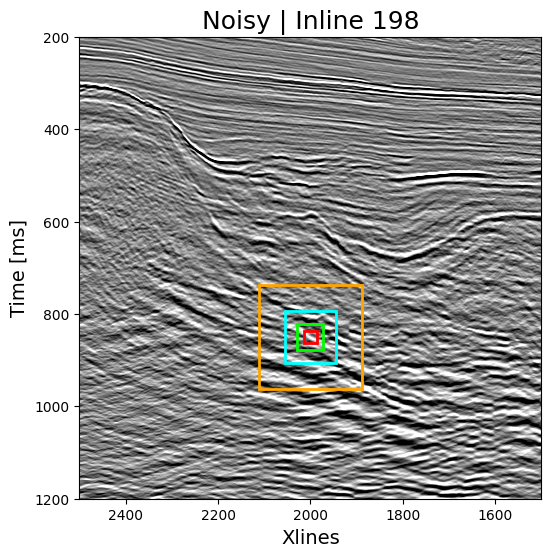

In [66]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches

# Visualize the inline
plt.figure(figsize=(20, 6))
plt.imshow(cubeNoisy[iline, :, :].T, cmap = 'gray', aspect='equal', vmin = -amplitude_max, vmax = amplitude_max)
plt.xlabel('Xlines', fontsize = 14)
plt.ylabel('Time [ms]', fontsize = 14)
plt.title('Noisy | Inline %d' %iline, fontsize = 18)
plt.xlim(2500, 1500)
plt.ylim(1200, 200)

color_frames = ['red', 'lime', 'cyan', 'orange', 'magenta', 'blue']

for i in patchSizeList:
    rect = patches.Rectangle((2000-(i/2), 850-(i/2)), i, i, linewidth=2.0, edgecolor=color_frames[0], facecolor='none')
    plt.gca().add_patch(rect)
    color_frames = color_frames[1:]

plt.show()

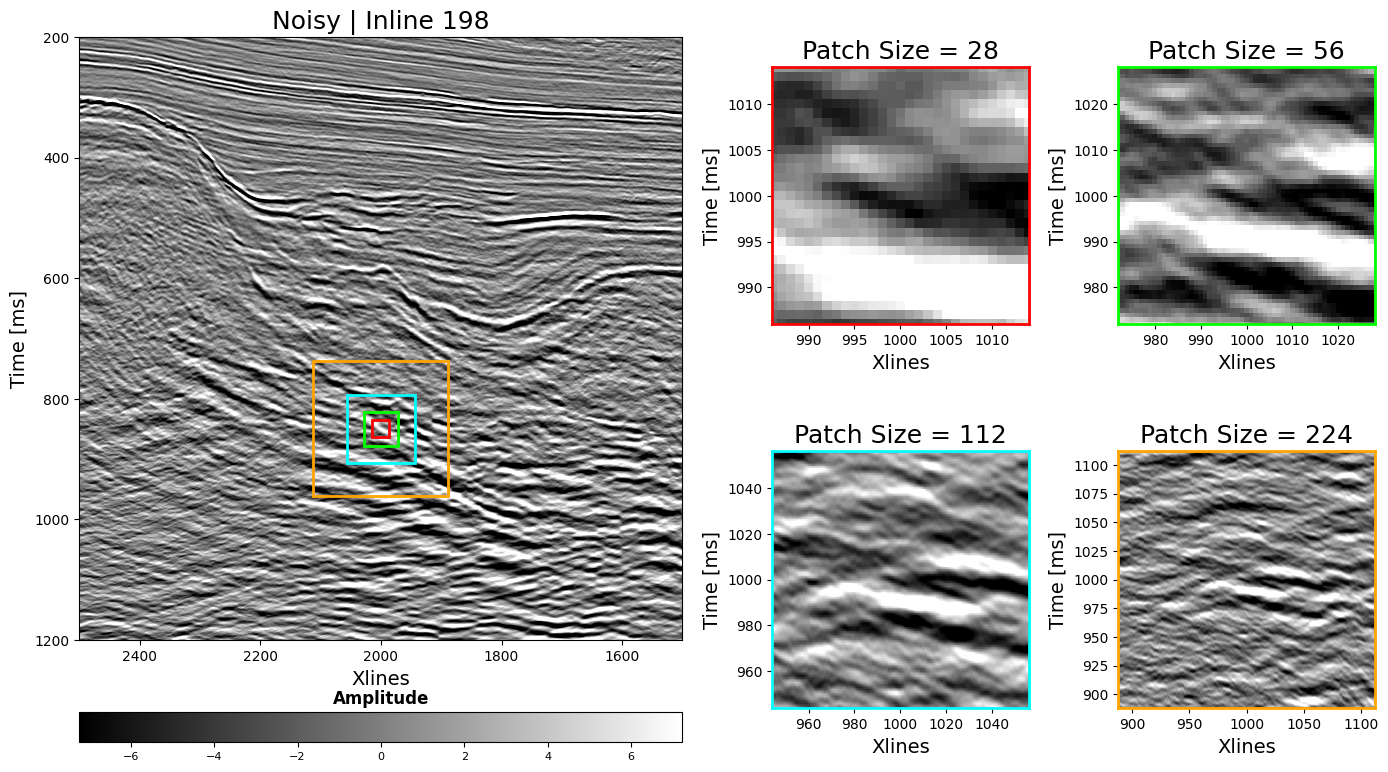

In [163]:
plt.figure(figsize=(14,8))

plt.subplot(2,4,(1, 6))
plt.imshow(cubeNoisy[iline, :, :].T, cmap = 'gray', aspect='equal', vmin = -amplitude_max, vmax = amplitude_max)
plt.xlabel('Xlines', fontsize = 14)
plt.ylabel('Time [ms]', fontsize = 14)
plt.title('Noisy | Inline %d' %iline, fontsize = 18)
plt.xlim(2500, 1500)
plt.ylim(1200, 200)

color_frames = ['red', 'lime', 'cyan', 'orange']

for i in patchSizeList:
    rect = patches.Rectangle((2000-(i/2), 850-(i/2)), i, i, linewidth=2.0, edgecolor=color_frames[0], facecolor='none')
    plt.gca().add_patch(rect)
    color_frames = color_frames[1:]

# Add horizontal colorbar
cb = plt.colorbar(orientation='horizontal', pad = 0.1, fraction = 0.05)
cb.ax.set_title('Amplitude', fontsize=12, weight='bold')
cb.ax.tick_params(labelsize=8)


plt.subplot(2,4,3)
ax = plt.gca()
ax.spines['bottom'].set_color('red')
ax.spines['top'].set_color('red')
ax.spines['right'].set_color('red')
ax.spines['left'].set_color('red')
ax.spines['bottom'].set_linewidth(2.0)
ax.spines['top'].set_linewidth(2.0)
ax.spines['right'].set_linewidth(2.0)
ax.spines['left'].set_linewidth(2.0)

plt.imshow(cubeNoisy[iline, :, :].T, cmap = 'gray', aspect='equal', vmin = -amplitude_max, vmax = amplitude_max)
plt.xlabel('Xlines', fontsize = 14)
plt.ylabel('Time [ms]', fontsize = 14)
plt.title('Patch Size = 28', fontsize = 18)
plt.xlim((2500 - 1500)-(28/2), (2500 - 1500)+(28/2))
plt.ylim((1200-200)-(28/2), (1200-200)+(28/2))

plt.subplot(2,4,4)
ax = plt.gca()
ax.spines['bottom'].set_color('lime')
ax.spines['top'].set_color('lime')
ax.spines['right'].set_color('lime')
ax.spines['left'].set_color('lime')

ax.spines['bottom'].set_linewidth(2.0)
ax.spines['top'].set_linewidth(2.0)
ax.spines['right'].set_linewidth(2.0)
ax.spines['left'].set_linewidth(2.0)

plt.imshow(cubeNoisy[iline, :, :].T, cmap = 'gray', aspect='equal', vmin = -amplitude_max, vmax = amplitude_max)
plt.xlabel('Xlines', fontsize = 14)
plt.ylabel('Time [ms]', fontsize = 14)
plt.title('Patch Size = 56', fontsize = 18)
plt.xlim((2500 - 1500)-(56/2), (2500 - 1500)+(56/2))
plt.ylim((1200-200)-(56/2), (1200-200)+(56/2))

plt.subplot(2,4,7)
ax = plt.gca()
ax.spines['bottom'].set_color('cyan')
ax.spines['top'].set_color('cyan')
ax.spines['right'].set_color('cyan')
ax.spines['left'].set_color('cyan')

ax.spines['bottom'].set_linewidth(2.0)
ax.spines['top'].set_linewidth(2.0)
ax.spines['right'].set_linewidth(2.0)
ax.spines['left'].set_linewidth(2.0)

plt.imshow(cubeNoisy[iline, :, :].T, cmap = 'gray', aspect='equal', vmin = -amplitude_max, vmax = amplitude_max)
plt.xlabel('Xlines', fontsize = 14)
plt.ylabel('Time [ms]', fontsize = 14)
plt.title('Patch Size = 112', fontsize = 18)
plt.xlim((2500 - 1500)-(112/2), (2500 - 1500)+(112/2))
plt.ylim((1200-200)-(112/2), (1200-200)+(112/2))

plt.subplot(2,4,8)
ax = plt.gca()
ax.spines['bottom'].set_color('orange')
ax.spines['top'].set_color('orange')
ax.spines['right'].set_color('orange')
ax.spines['left'].set_color('orange')

ax.spines['bottom'].set_linewidth(2.0)
ax.spines['top'].set_linewidth(2.0)
ax.spines['right'].set_linewidth(2.0)
ax.spines['left'].set_linewidth(2.0)

plt.imshow(cubeNoisy[iline, :, :].T, cmap = 'gray', aspect='equal', vmin = -amplitude_max, vmax = amplitude_max)
plt.xlabel('Xlines', fontsize = 14)
plt.ylabel('Time [ms]', fontsize = 14)
plt.title('Patch Size = 224', fontsize = 18)
plt.xlim((2500 - 1500)-(224/2), (2500 - 1500)+(224/2))
plt.ylim((1200-200)-(224/2), (1200-200)+(224/2))

plt.tight_layout()
plt.show()


#### Inline

In [ ]:
plt.figure(figsize=(20, 6))
plt.imshow(cubeNoisy[iline, :, :].T, cmap = 'gray', aspect='equal', vmin = -amplitude_max, vmax = amplitude_max)

for m in range(xline_num_patches):
    for n in range(time_num_patches):
        i = m*patchSize+patchSize//2
        j = n*patchSize+patchSize//2
        rect = plt.Rectangle((m*patchSize, n*patchSize), patchSize, patchSize, linewidth=0.5, edgecolor='r', facecolor='none')
        plt.gca().add_patch(rect)
        plt.text(i, j, str(m*time_num_patches+n), color='r', fontsize=6, ha='center', va='center')

plt.xlabel('Xlines', fontsize = 14)
plt.ylabel('Time [ms]', fontsize = 14)
plt.title('Noisy | Inline %d' %iline, fontsize = 18)
plt.savefig('/home/roderickperez/Documents/DS_Projects_Ubuntu/Denoising_Seismic_AutoEncoder/images/2D_iline_noisyPatches.png', dpi = 500)
plt.show()

#### Xline

In [ ]:
plt.figure(figsize=(20, 6))
plt.imshow(cubeNoisy[:, xline, :].T, cmap = 'gray', aspect='equal', vmin = -amplitude_max, vmax = amplitude_max)

for m in range(iline_num_patches):
    for n in range(time_num_patches):
        i = m*patchSize+patchSize//2
        j = n*patchSize+patchSize//2
        rect = plt.Rectangle((m*patchSize, n*patchSize), patchSize, patchSize, linewidth=0.5, edgecolor='r', facecolor='none')
        plt.gca().add_patch(rect)
        plt.text(i, j, str(m*time_num_patches+n), color='r', fontsize=6, ha='center', va='center')

plt.xlabel('Inlines', fontsize = 14)
plt.ylabel('Time [ms]', fontsize = 14)
plt.title('Noisy | Xline %d' %xline, fontsize = 18)
plt.savefig('/home/roderickperez/Documents/DS_Projects_Ubuntu/Denoising_Seismic_AutoEncoder/images/2D_xline_noisyPatches.png', dpi = 500)
plt.show()

#### Time

In [ ]:
plt.figure(figsize=(20, 6))
plt.imshow(cubeNoisy[:, :, time].T, cmap = 'gray', aspect='equal', vmin = -amplitude_max, vmax = amplitude_max)

for m in range(iline_num_patches):
    for n in range(xline_num_patches):
        i = m*patchSize+patchSize//2
        j = n*patchSize+patchSize//2
        rect = plt.Rectangle((m*patchSize, n*patchSize), patchSize, patchSize, linewidth=0.5, edgecolor='r', facecolor='none')
        plt.gca().add_patch(rect)
        plt.text(i, j, str(m*xline_num_patches+n), color='r', fontsize=6, ha='center', va='center')

plt.xlabel('Inlines', fontsize = 14)
plt.ylabel('Xlines', fontsize = 14)
plt.title('Noisy | Time %d' %time, fontsize = 18)
plt.savefig('/home/roderickperez/Documents/DS_Projects_Ubuntu/Denoising_Seismic_AutoEncoder/images/2D_time_noisyPatches.png', dpi = 500)
plt.show()

---

### Extract Patches

In [ ]:
# Select a random value for the inline, crossline, time slice
random_iline = np.random.randint(0, cubeNoiseless.shape[0])
random_xline = np.random.randint(0, cubeNoiseless.shape[1])
random_time = np.random.randint(0, cubeNoiseless.shape[2])

### Noisy Volume

#### Inline

In [ ]:
# Extract the individual patches for each Inline

iline_num_patches = cubeNoisy.shape[0]
xline_num_patches = cubeNoisy.shape[1] // patchSize
time_num_patches = cubeNoisy.shape[2] // patchSize

iline_noisy_patches = {}
count = 0

for i in range(iline_num_patches):
    for j in range(xline_num_patches):
        for k in range(time_num_patches):
            iline_start, iline_end = i, i + 1
            xline_start, xline_end = j * patchSize, (j + 1) * patchSize
            time_start, time_end = k * patchSize, (k + 1) * patchSize
            
            patch = cubeNoisy[iline_start:iline_end, xline_start:xline_end, time_start:time_end].squeeze()
            
            iline_noisy_patches[count] = patch
            count += 1

In [ ]:
len(iline_noisy_patches)

In [ ]:
# Display a random single inline patch
plt.figure(figsize=(10, 6))
plt.imshow(iline_noisy_patches[random_iline].T, cmap = 'gray', aspect='equal', vmin = -amplitude_max, vmax = amplitude_max)
plt.colorbar()
plt.xlabel('Xlines', fontsize = 14)
plt.ylabel('Time [ms]', fontsize = 14)
plt.title('Noisy | Inline %d' %random_iline, fontsize = 18)
plt.show()

In [ ]:
# Save the individual patches as separate .npy arrays
for i in range(len(iline_noisy_patches)):
    np.save('/home/roderickperez/Documents/DS_Projects_Ubuntu/Denoising_Seismic_AutoEncoder/data/InforPetrol/patches/patches_size_{}/noisy/inline_2D_noisy/inline_2D_noisy_patch_{}.npy'.format(patchSize, i), iline_noisy_patches[i])

#### Xline

In [ ]:
# Extract the individual patches for each Xline
iline_num_patches = cubeNoisy.shape[0] // patchSize
xline_num_patches = cubeNoisy.shape[1]
time_num_patches = cubeNoisy.shape[2] // patchSize

xline_noisy_patches = {}
count = 0

for j in range(xline_num_patches):
    for i in range(iline_num_patches):
        for k in range(time_num_patches):
            iline_start, iline_end = i * patchSize, (i + 1) * patchSize
            xline_slice = j
            time_start, time_end = k * patchSize, (k + 1) * patchSize
            
            patch = cubeNoisy[iline_start:iline_end, xline_slice:xline_slice+1, time_start:time_end].squeeze()
            
            xline_noisy_patches[count] = patch
            count += 1

In [ ]:
len(xline_noisy_patches)

In [ ]:
# Display a random single xline patch
plt.figure(figsize=(10, 6))
plt.imshow(xline_noisy_patches[random_xline].T, cmap = 'gray', aspect='equal', vmin = -amplitude_max, vmax = amplitude_max)
plt.colorbar()
plt.xlabel('Inlines', fontsize = 14)
plt.ylabel('Time [ms]', fontsize = 14)
plt.title('Noisy | Xline %d' %random_xline, fontsize = 18)
plt.show()

In [ ]:
# Save the individual patches as separate .npy arrays
for i in range(len(xline_noisy_patches)):
    np.save('/home/roderickperez/Documents/DS_Projects_Ubuntu/Denoising_Seismic_AutoEncoder/data/InforPetrol/patches/patches_size_{}/noisy/xline_2D_noisy/xline_2D_noisy_patch_{}.npy'.format(patchSize, i), xline_noisy_patches[i])

#### Time

In [ ]:
# Extract the individual patches for each Time
iline_num_patches = cubeNoisy.shape[0] // patchSize
xline_num_patches = cubeNoisy.shape[1] // patchSize
time_num_patches = cubeNoisy.shape[2]

time_noisy_patches = {}
count = 0

for k in range(time_num_patches):
    for i in range(iline_num_patches):
        for j in range(xline_num_patches):
            iline_start, iline_end = i * patchSize, (i + 1) * patchSize
            xline_start, xline_end = j * patchSize, (j + 1) * patchSize
            time_slice = k
            
            patch = cubeNoisy[iline_start:iline_end, xline_start:xline_end, time_slice:time_slice+1].squeeze()
            
            time_noisy_patches[count] = patch
            count += 1

In [ ]:
len(time_noisy_patches)

In [ ]:
# Display a random single tim patch
plt.figure(figsize=(10, 6))
plt.imshow(time_noisy_patches[random_time].T, cmap = 'gray', aspect='equal', vmin = -amplitude_max, vmax = amplitude_max)
plt.colorbar()
plt.xlabel('Inlines', fontsize = 14)
plt.ylabel('Xlines', fontsize = 14)
plt.title('Noisy | Time %d' %random_time, fontsize = 18)
plt.show()

In [ ]:
# Save the individual patches as separate .npy arrays
for i in range(len(time_noisy_patches)):
    np.save('/home/roderickperez/Documents/DS_Projects_Ubuntu/Denoising_Seismic_AutoEncoder/data/InforPetrol/patches/patches_size_{}/noisy/time_2D_noisy/time_2D_noisy_patch_{}.npy'.format(patchSize, i), time_noisy_patches[i])

---

---

### Noiseless Volume

#### Inline

In [ ]:
# Extract the individual patches for each Inline

iline_num_patches = cubeNoiseless.shape[0]
xline_num_patches = cubeNoiseless.shape[1] // patchSize
time_num_patches = cubeNoiseless.shape[2] // patchSize

iline_noiseless_patches = {}
count = 0

for i in range(iline_num_patches):
    for j in range(xline_num_patches):
        for k in range(time_num_patches):
            iline_start, iline_end = i, i + 1
            xline_start, xline_end = j * patchSize, (j + 1) * patchSize
            time_start, time_end = k * patchSize, (k + 1) * patchSize
            
            patch = cubeNoiseless[iline_start:iline_end, xline_start:xline_end, time_start:time_end].squeeze()
            
            iline_noiseless_patches[count] = patch
            count += 1

In [ ]:
len(iline_noiseless_patches)

In [ ]:
# Display a random single inline patch
plt.figure(figsize=(10, 6))
plt.imshow(iline_noiseless_patches[random_iline].T, cmap = 'gray', aspect='equal', vmin = -amplitude_max, vmax = amplitude_max)
plt.colorbar()
plt.xlabel('Xlines', fontsize = 14)
plt.ylabel('Time [ms]', fontsize = 14)
plt.title('Noiseless | Inline %d' %random_iline, fontsize = 18)
plt.show()

In [ ]:
# Make a 1 row 3 column plot. 1st plot in the noisy inline, 2nd plot is the noiseless inline, 3rd plot is the difference between the two
fig, axs = plt.subplots(1, 3, figsize=(20, 6))
axs[0].imshow(iline_noisy_patches[random_iline].T, cmap = 'gray', aspect='equal', vmin = -amplitude_max, vmax = amplitude_max)
axs[0].set_title('Noisy | Inline %d' %random_iline, fontsize = 18)
axs[1].imshow(iline_noiseless_patches[random_iline].T, cmap = 'gray', aspect='equal', vmin = -amplitude_max, vmax = amplitude_max)
axs[1].set_title('Noiseless | Inline %d' %random_iline, fontsize = 18)
axs[2].imshow(iline_noisy_patches[random_iline].T - iline_noiseless_patches[random_iline].T, cmap = 'gray', aspect='equal', vmin = -amplitude_max, vmax = amplitude_max)
axs[2].set_title('Difference | Inline %d' %random_iline, fontsize = 18)
plt.show()

In [ ]:
# Save the individual patches as separate .npy arrays
for i in range(len(iline_noiseless_patches)):
    np.save('/home/roderickperez/Documents/DS_Projects_Ubuntu/Denoising_Seismic_AutoEncoder/data/InforPetrol/patches/patches_size_{}/noiseless/inline_2D_noiseless/inline_2D_noiseless_patch_{}.npy'.format(patchSize, i), iline_noiseless_patches[i])

#### Xline

In [ ]:
# Extract the individual patches for each Xline
iline_num_patches = cubeNoiseless.shape[0] // patchSize
xline_num_patches = cubeNoiseless.shape[1]
time_num_patches = cubeNoiseless.shape[2] // patchSize

xline_noiseless_patches = {}
count = 0

for j in range(xline_num_patches):
    for i in range(iline_num_patches):
        for k in range(time_num_patches):
            iline_start, iline_end = i * patchSize, (i + 1) * patchSize
            xline_slice = j
            time_start, time_end = k * patchSize, (k + 1) * patchSize
            
            patch = cubeNoiseless[iline_start:iline_end, xline_slice:xline_slice+1, time_start:time_end].squeeze()
            
            xline_noiseless_patches[count] = patch
            count += 1

In [ ]:
len(xline_noiseless_patches)

In [ ]:
# Display a random single xline patch
plt.figure(figsize=(10, 6))
plt.imshow(xline_noiseless_patches[random_xline].T, cmap = 'gray', aspect='equal', vmin = -amplitude_max, vmax = amplitude_max)
plt.colorbar()
plt.xlabel('Inlines', fontsize = 14)
plt.ylabel('Time [ms]', fontsize = 14)
plt.title('Noiseless | Xline %d' %random_xline, fontsize = 18)
plt.show()

In [ ]:
# Make a 1 row 3 column plot. 1st plot in the noisy inline, 2nd plot is the noiseless inline, 3rd plot is the difference between the two
fig, axs = plt.subplots(1, 3, figsize=(20, 6))
axs[0].imshow(xline_noisy_patches[random_xline].T, cmap = 'gray', aspect='equal', vmin = -amplitude_max, vmax = amplitude_max)
axs[0].set_title('Noisy | Xline %d' %random_xline, fontsize = 18)
axs[1].imshow(xline_noiseless_patches[random_xline].T, cmap = 'gray', aspect='equal', vmin = -amplitude_max, vmax = amplitude_max)
axs[1].set_title('Noiseless | Xline %d' %random_xline, fontsize = 18)
axs[2].imshow(xline_noisy_patches[random_xline].T - xline_noiseless_patches[random_xline].T, cmap = 'gray', aspect='equal', vmin = -amplitude_max, vmax = amplitude_max)
axs[2].set_title('Difference | Xline %d' %random_xline, fontsize = 18)
plt.show()

In [ ]:
# Save the individual patches as separate .npy arrays
for i in range(len(xline_noiseless_patches)):
    np.save('/home/roderickperez/Documents/DS_Projects_Ubuntu/Denoising_Seismic_AutoEncoder/data/InforPetrol/patches/patches_size_{}/noiseless/xline_2D_noiseless/xline_2D_noiseless_patch_{}.npy'.format(patchSize, i), xline_noiseless_patches[i])

#### Time

In [ ]:
# Extract the individual patches for each Time
iline_num_patches = cubeNoiseless.shape[0] // patchSize
xline_num_patches = cubeNoiseless.shape[1] // patchSize
time_num_patches = cubeNoiseless.shape[2]

time_noiseless_patches = {}
count = 0

for k in range(time_num_patches):
    for i in range(iline_num_patches):
        for j in range(xline_num_patches):
            iline_start, iline_end = i * patchSize, (i + 1) * patchSize
            xline_start, xline_end = j * patchSize, (j + 1) * patchSize
            time_slice = k
            
            patch = cubeNoiseless[iline_start:iline_end, xline_start:xline_end, time_slice:time_slice+1].squeeze()
            
            time_noiseless_patches[count] = patch
            count += 1

In [ ]:
len(time_noiseless_patches)

In [ ]:
# Display a random single tim patch
plt.figure(figsize=(10, 6))
plt.imshow(time_noiseless_patches[random_time].T, cmap = 'gray', aspect='equal', vmin = -amplitude_max, vmax = amplitude_max)
plt.colorbar()
plt.xlabel('Inlines', fontsize = 14)
plt.ylabel('Xlines', fontsize = 14)
plt.title('Noiseless | Time %d' %random_time, fontsize = 18)
plt.show()

In [ ]:
# Make a 1 row 3 column plot. 1st plot in the noisy inline, 2nd plot is the noiseless inline, 3rd plot is the difference between the two
fig, axs = plt.subplots(1, 3, figsize=(20, 6))
axs[0].imshow(time_noisy_patches[random_time].T, cmap = 'gray', aspect='equal', vmin = -amplitude_max, vmax = amplitude_max)
axs[0].set_title('Noisy | Inline %d' %random_time, fontsize = 18)
axs[1].imshow(time_noiseless_patches[random_time].T, cmap = 'gray', aspect='equal', vmin = -amplitude_max, vmax = amplitude_max)
axs[1].set_title('Noiseless | Inline %d' %random_time, fontsize = 18)
axs[2].imshow(time_noisy_patches[random_time].T - time_noiseless_patches[random_time].T, cmap = 'gray', aspect='equal', vmin = -amplitude_max, vmax = amplitude_max)
axs[2].set_title('Difference | Time %d' %random_time, fontsize = 18)
plt.show()

In [ ]:
# Save the individual patches as separate .npy arrays
for i in range(len(time_noisy_patches)):
    np.save('/home/roderickperez/Documents/DS_Projects_Ubuntu/Denoising_Seismic_AutoEncoder/data/InforPetrol/patches/patches_size_{}/noiseless/time_2D_noiseless/time_2D_noiseless_patch_{}.npy'.format(patchSize, i), time_noiseless_patches[i])